## Imports / Data Preparation

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tarfile
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
#directories for saving training progress
from google.colab import drive

drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/training_progress.'
os.makedirs(save_dir, exist_ok=True)
checkpoint_path = os.path.join(save_dir, 'cp-{epoch:04d}.ckpt')

save_dir_re = '/content/drive/My Drive/training_progress'
os.makedirs(save_dir_re, exist_ok=True)
checkpoint_path_re = os.path.join(save_dir_re, 'cp-{epoch:04d}.ckpt')

save_dir_buf = '/content/drive/My Drive/training_progress'
os.makedirs(save_dir_buf, exist_ok=True)
checkpoint_path_buf = os.path.join(save_dir_buf, 'cp-{epoch:04d}.ckpt')

Mounted at /content/drive


In [3]:
tf.device('/GPU:0')

Download CIFAR-10 dataset from the source:

In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2025-04-11 12:55:01--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  50.0MB/s    in 3.6s    

2025-04-11 12:55:05 (44.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### Preprocessing

In [ ]:
def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(-1, 3, 32, 32).astype("float32")
        X = np.transpose(X, (0, 2, 3, 1))  # Converting to NHWC
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    X_train = []
    Y_train = []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(batch_file)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    # Load test batch
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

data_dir = 'cifar-10-batches-py'  

# Load the data
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


In [ ]:
# Preprocess the data
def preprocess_data(X, Y):
    X = X / 255.0  # Normalize to [0,1]
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    return X, Y

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


### Important constants/hyperparameters

Some constants/information about the dataset:

In [7]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-4

In [ ]:
# Creating TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_p, Y_train_p))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_p, Y_test_p))
test_dataset = test_dataset.batch(batch_size)

In [9]:
image_shape = X_train.shape[1:] # Shape of CIFAR-10 images
image_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
n_class = len(image_labels)  # Number of classes

### Data Visualization

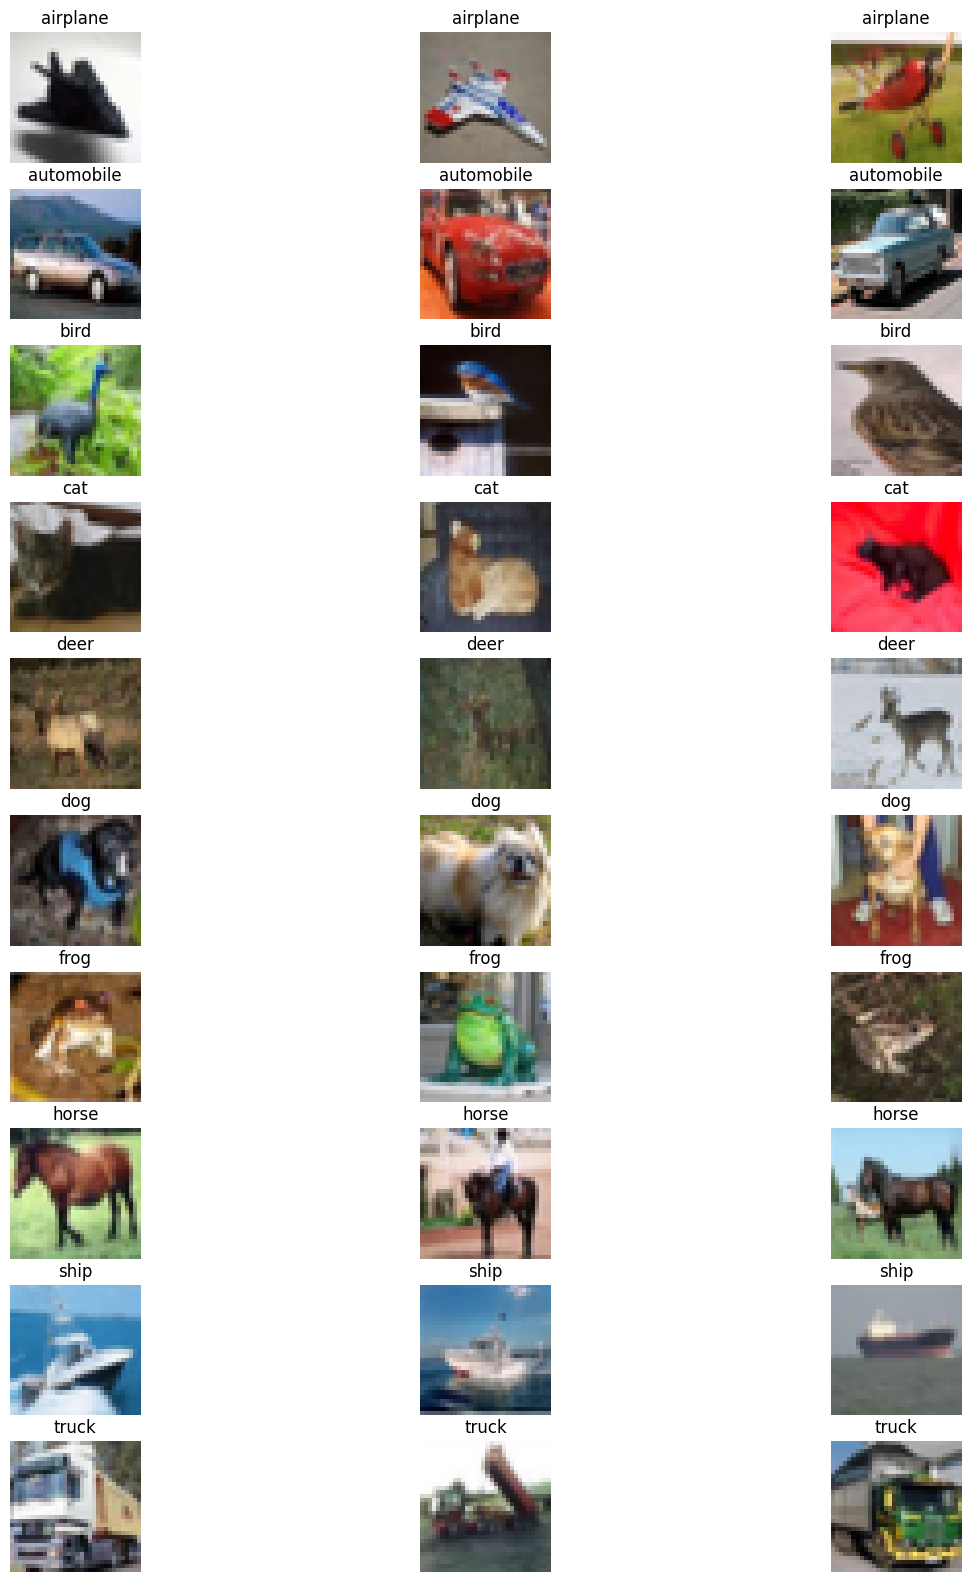

In [ ]:
def visualize_samples(X, Y, num_samples=30):

    fig, axes = plt.subplots(10, 3, figsize=(15, 20))

    for i in range(10): 
      for j in range(3): 
        image = X[np.where(Y==i)[0][j]]*255
        label_index = Y[np.where(Y==i)[0][j]]
        label_name = image_labels[label_index]  

        axes[i][j].imshow(image.astype("uint8"))
        axes[i][j].set_title(label_name)
        axes[i][j].axis('off')

    plt.show()

# Visualizing 30 samples
visualize_samples(X_train_p, Y_train_p, num_samples=30)


## Classification Task

### Model

In [ ]:
class ResBlock(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsampling = downsampling
        self.relu1 = layers.LeakyReLU() #activation function
        self.relu2 = layers.LeakyReLU()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal', padding="same") #convolutional layer
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal', strides = (2 if downsampling else 1), padding="same")


        if downsampling or in_channels != out_channels:    #skip connection
            self.skip = layers.Conv2D(out_channels, kernel_size=1, kernel_initializer = 'he_normal', strides=(2 if downsampling else 1), padding="same", use_bias=False)
        else:
            self.skip = lambda x: x


    def call(self, x):

        residual = self.skip(x)

        x = self.relu1(x)
        x = self.conv1(x)
        x = self.relu2(x)
        x = self.conv2(x)

        x = layers.add([x, residual])

        return x


In [ ]:
class WRN(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRN, self).__init__()
        self.num_classes = num_classes
        self.conv1 = layers.Conv2D(16, kernel_size=3, kernel_initializer = 'he_normal', padding="same")
        self.block1 = ResBlock(16, 64, downsampling = False)
        self.block2 = ResBlock(64, 64, downsampling = False)
        self.block3 = ResBlock(64, 128, downsampling = True)
        self.block4 = ResBlock(128, 128, downsampling = False)
        self.block5 = ResBlock(128, 256, downsampling = True)
        self.block6 = ResBlock(256, 256, downsampling = False)
        self.relu = layers.LeakyReLU()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)

    def call(self, x):
      x = self.conv1(x)
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)
      x = self.block5(x)
      x = self.block6(x)
      x = self.relu(x)
      x = self.avgpool(x)
      x = self.dense(x)

      return x

### Part 1 Training

In [ ]:
def evaluate_accuracy(model, dataset):
    correct = 0
    total = 0
    with tqdm(dataset, unit="batch") as tepoch:
        tepoch.set_description(f"Evaluating")
        for batch_x, batch_y in tepoch:
            batch_size = tf.shape(batch_x)[0]
            
            logits = model(batch_x)
            casted = tf.cast(batch_y, dtype=tf.int64)


            preds = tf.argmax(logits, axis=1)
            correct_predictions = tf.reduce_sum(tf.cast(preds == casted, tf.int64))
            correct += correct_predictions.numpy()
            total += batch_size.numpy()
            accuracy = correct/total

    return accuracy

In [ ]:
def part1_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sigma : float = 0.03) -> dict:

    # one-hot encoding
    one_hot_encoded = tf.one_hot(label, model.num_classes)

    # adding noise for robustness
    data_augmentation = tf.random.normal(shape=tf.shape(data), mean = 0.0, stddev=sigma)
    data = data + data_augmentation


    # training the model
    with tf.GradientTape() as g:
        logits = model(data)
        loss = tf.keras.losses.categorical_crossentropy(one_hot_encoded, logits, from_logits = True)
        loss = tf.reduce_mean(loss)

    gradients = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))

    return {
        "loss": loss
    }


In [ ]:
def train_loop_1(model, optimizer, train_step, epochs : int = 20, save_interval : int = 5):
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
               
                loss_dict = train_step(optimizer, model, batch_x, batch_y)
                epoch_loss += loss_dict["loss"]
                num_batches += 1
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
        # Save the model weights after 5 epochs
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')

### Execute training

In [ ]:
model = WRN(num_classes=n_class)
optimizer = optimizers.Adam(learning_rate=learning_rate)

In [ ]:
train_loop_1(model, optimizer, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.41batch/s]


Test Accuracy: 40.23%
Epoch 1, Average Loss: 2.1654


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 46.81%
Epoch 2, Average Loss: 1.5433


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.01batch/s]


Test Accuracy: 49.86%
Epoch 3, Average Loss: 1.4140


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 54.78%
Epoch 4, Average Loss: 1.3038


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.12batch/s]


Test Accuracy: 55.11%
Epoch 5, Average Loss: 1.2145


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 56.83%
Epoch 6, Average Loss: 1.1408


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 61.08%
Epoch 7, Average Loss: 1.0587


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.14batch/s]


Test Accuracy: 64.35%
Epoch 8, Average Loss: 0.9908


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 66.17%
Epoch 9, Average Loss: 0.9344


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.17batch/s]


Test Accuracy: 67.54%
Epoch 10, Average Loss: 0.8695


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.66batch/s]


Test Accuracy: 67.53%
Epoch 11, Average Loss: 0.8248


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.53batch/s]


Test Accuracy: 67.73%
Epoch 12, Average Loss: 0.7749


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.14batch/s]


Test Accuracy: 70.38%
Epoch 13, Average Loss: 0.7283


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.96batch/s]


Test Accuracy: 71.64%
Epoch 14, Average Loss: 0.6785


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 71.95%
Epoch 15, Average Loss: 0.6426


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.06batch/s]


Test Accuracy: 72.29%
Epoch 16, Average Loss: 0.5944


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.20batch/s]


Test Accuracy: 73.06%
Epoch 17, Average Loss: 0.5510


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 22.32batch/s]


Test Accuracy: 73.27%
Epoch 18, Average Loss: 0.5182


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.96batch/s]


Test Accuracy: 73.22%
Epoch 19, Average Loss: 0.4725


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.89batch/s]


Test Accuracy: 73.19%
Epoch 20, Average Loss: 0.4383


In [19]:
print(evaluate_accuracy(model, test_dataset))

Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.13batch/s]

0.7319


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 24.89batch/s]


Test Accuracy: 0.7319


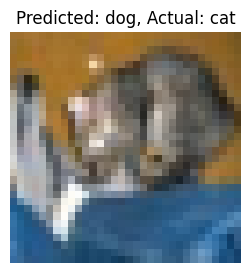

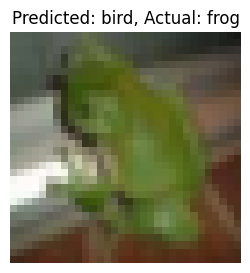

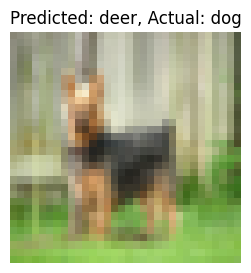

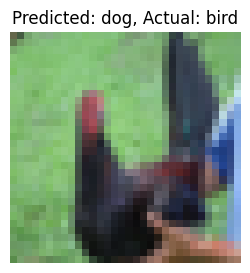

In [ ]:
# Printing test accuracy and displaying some misclassified samples
test_accuracy = evaluate_accuracy(model, test_dataset)
print(f"Test Accuracy: {test_accuracy}")


test_predictions = []
test_labels = []

for images, labels in test_dataset:
    predictions = tf.argmax(model(images), axis=1)
    test_predictions.extend(predictions.numpy())
    test_labels.extend(labels.numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)


misclassified_indices = np.where(test_predictions != test_labels)[0]
misclassified_images = X_test_p[misclassified_indices]
misclassified_labels = test_labels[misclassified_indices]
misclassified_predictions = test_predictions[misclassified_indices]

for i in range(4):
    plt.figure(figsize=(3, 3))
    plt.imshow(misclassified_images[i])
    plt.title(f"Predicted: {image_labels[misclassified_predictions[i]]}, Actual: {image_labels[misclassified_labels[i]]}")
    plt.axis('off')
    plt.show()


### Regularization

In [ ]:
# ResNet with batch normalization
class ResBlockRE(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlockRE, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsampling = downsampling
        self.relu1 = layers.LeakyReLU()
        self.relu2 = layers.LeakyReLU()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, kernel_initializer = 'he_normal',padding="same")
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides = (2 if downsampling else 1), kernel_initializer = 'he_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.norm2 = layers.BatchNormalization()


        if downsampling or in_channels != out_channels:
            self.skip = layers.Conv2D(out_channels, kernel_size=1, strides=(2 if downsampling else 1), kernel_initializer = 'he_normal', padding="same", use_bias=False)
        else:
            self.skip = lambda x: x



    def call(self, x):
        residual = self.skip(x)
        x = self.relu1(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.norm2(x)

        # print("Shape of x:", tf.shape(x))
        # print("Shape of residual:", tf.shape(residual))
        x = layers.add([x, residual])

        return x
    

class WRNRE(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRNRE, self).__init__()
        self.num_classes = num_classes
        self.conv1 = layers.Conv2D(16, kernel_size=3, kernel_initializer = 'he_normal', padding="same")
        self.block1 = ResBlockRE(16, 64, downsampling = False)
        self.block2 = ResBlockRE(64, 64, downsampling = False)
        self.block3 = ResBlockRE(64, 128, downsampling = True)
        self.block4 = ResBlockRE(128, 128, downsampling = False)
        self.block5 = ResBlockRE(128, 256, downsampling = True)
        self.block6 = ResBlockRE(256, 256, downsampling = False)
        self.relu = layers.LeakyReLU()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)


    def call(self, x):
        x = self.conv1(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = self.dense(x)
        return x


In [ ]:
model_re = WRNRE(num_classes=n_class)
optimizer_re = optimizers.Adam(learning_rate=learning_rate)


In [ ]:
train_loop_1(model_re, optimizer_re, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.13batch/s]


Test Accuracy: 39.37%
Epoch 1, Average Loss: 2.2382


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.79batch/s]


Test Accuracy: 45.07%
Epoch 2, Average Loss: 1.5893


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.16batch/s]


Test Accuracy: 50.84%
Epoch 3, Average Loss: 1.4481


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.08batch/s]


Test Accuracy: 53.94%
Epoch 4, Average Loss: 1.3415


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 17.17batch/s]


Test Accuracy: 57.04%
Epoch 5, Average Loss: 1.2508


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.97batch/s]


Test Accuracy: 61.26%
Epoch 6, Average Loss: 1.1652


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 18.45batch/s]


Test Accuracy: 61.50%
Epoch 7, Average Loss: 1.0833


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.92batch/s]


Test Accuracy: 64.46%
Epoch 8, Average Loss: 1.0198


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 64.24%
Epoch 9, Average Loss: 0.9522


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.75batch/s]


Test Accuracy: 66.29%
Epoch 10, Average Loss: 0.8963


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 66.68%
Epoch 11, Average Loss: 0.8451


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.11batch/s]


Test Accuracy: 70.22%
Epoch 12, Average Loss: 0.7845


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 70.79%
Epoch 13, Average Loss: 0.7407


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 71.08%
Epoch 14, Average Loss: 0.6997


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 20.89batch/s]


Test Accuracy: 73.57%
Epoch 15, Average Loss: 0.6470


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.84batch/s]


Test Accuracy: 70.44%
Epoch 16, Average Loss: 0.6123


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]


Test Accuracy: 73.35%
Epoch 17, Average Loss: 0.5733


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.07batch/s]


Test Accuracy: 73.56%
Epoch 18, Average Loss: 0.5194


Evaluating: 100%|██████████| 79/79 [00:04<00:00, 16.85batch/s]


Test Accuracy: 72.75%
Epoch 19, Average Loss: 0.4960


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]

Test Accuracy: 73.79%
Epoch 20, Average Loss: 0.4486


## JEM Generation

### Energy Function

In [ ]:
# Energy function for the model
def energy(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None):
  logits = model(data)
  if label is not None:
    labels_onehot = tf.one_hot(label, depth=logits.shape[-1])
    return - tf.reduce_sum(logits * labels_onehot, axis=-1)
  else:
    return -tf.reduce_logsumexp(logits, axis=1)

In [ ]:
def visualize_energy(model: tf.keras.Model, sample_index: int = 20):
    real_image = X_test_p[sample_index]
    real_label = Y_test_p[sample_index]
    noise_image = np.random.uniform(0, 1, size=real_image.shape)
    grey_image = np.full(real_image.shape, 0.5)
    images = [real_image, noise_image, grey_image]
    exy = []
    ex = []
    names = ['Real', 'Noise', 'Grey']
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(names):
        exy.append(energy(model, tf.expand_dims(images[i], 0), real_label).numpy()[0])
        ex.append(energy(model, tf.expand_dims(images[i], 0)).numpy()[0])
        axes[i].imshow(images[i])
        axes[i].set_title(f"{ax} E(x,y): {exy[i]:.2f}, E(x) {ex[i]:.2f}")
        axes[i].axis('off')
    plt.show()

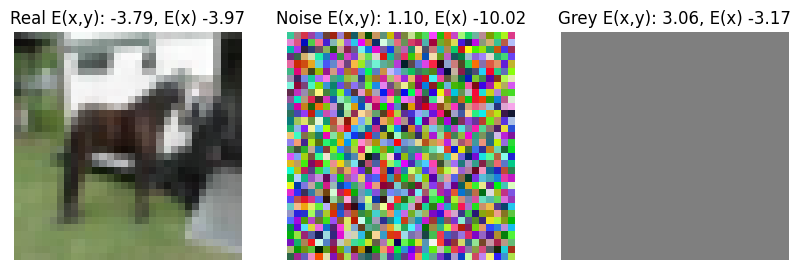

In [ ]:
visualize_energy(model, 20)

### Sampling x

In [ ]:
def sampling_step(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None, step_size : float = 1, noise_amp : float = 0.01):

    with tf.GradientTape(watch_accessed_variables = False) as g:
        g.watch(data)
        energy_value = energy(model, data, label)
        energy_sum = tf.reduce_sum(energy_value)

    gradient = g.gradient(energy_sum, data)
    data = tf.cast(data, tf.float32) - tf.cast(step_size, tf.float32) * tf.cast(gradient, tf.float32) + tf.random.normal(shape=tf.shape(data), mean = 0.0, stddev=noise_amp, dtype=tf.float32)
    data = tf.clip_by_value(data, 0, 1)

    return data

### Replay Buffer

In [ ]:
class SampleBuffer:
    """ A buffer storing some past trained (negative) samples. """
    def __init__(self, sample_shape, n_class : int, max_samples : int = 10000, dtype : np.dtype = np.float32):
        self.max_samples = max_samples
        self.sample_shape = sample_shape
        self.n_class = n_class
        self.dtype = dtype
        self.buffer = []

    def add_to_buffer(self, samples, ids):
        """ Add samples to replay buffer (self.buffer). If there are too many samples in the buffer, remove the oldest ones (first in, first out). """
        for i in range(len(samples)):
          self.buffer.append((samples[i], ids[i]))

        if (len(self.buffer) > self.max_samples):
            self.buffer = self.buffer[len(self.buffer)-self.max_samples:]


    def sample_from_buffer(self, n_samples : int, p_new : float = 0.05):
        """ Sample batch of n_sample samples, with each sample being either new (with probability p_new) or from buffer."""
        if len(self.buffer) == 0:
            n_new = n_samples
        else:
            n_new = np.random.binomial(n_samples, p_new)

        if n_new > 0:
            noise = np.random.uniform(0, 1, size=(n_new, *self.sample_shape))
            noise_class = np.random.randint(0, self.n_class, size=n_new)
        else:
            noise, noise_class = [], []

        if n_new < n_samples:
            indices = np.random.choice(len(self.buffer), size=n_samples - n_new, replace=False)
            replay = np.array([self.buffer[i][0] for i in indices])
            replay_class = np.array([self.buffer[i][1] for i in indices])
        else:
            replay, replay_class = [], []

        sample = tf.stack(list(noise) + list(replay), axis = 0)
        sample_class = tf.stack(list(noise_class) + list(replay_class), axis = 0)

        return sample, sample_class

In [ ]:
def visualize_buffer_samples(buffer : SampleBuffer, num_samples : int = 16, p_new : float = 0.05):
    samples, labels = buffer.sample_from_buffer(num_samples, p_new)
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(samples[i].numpy())
        plt.xlabel(image_labels[labels[i].numpy()])
    plt.show()

sample_shape = X_train_p[0].shape
buffer = SampleBuffer(sample_shape, n_class)
buffer.add_to_buffer(X_train_p[:100], Y_train_p[:100])

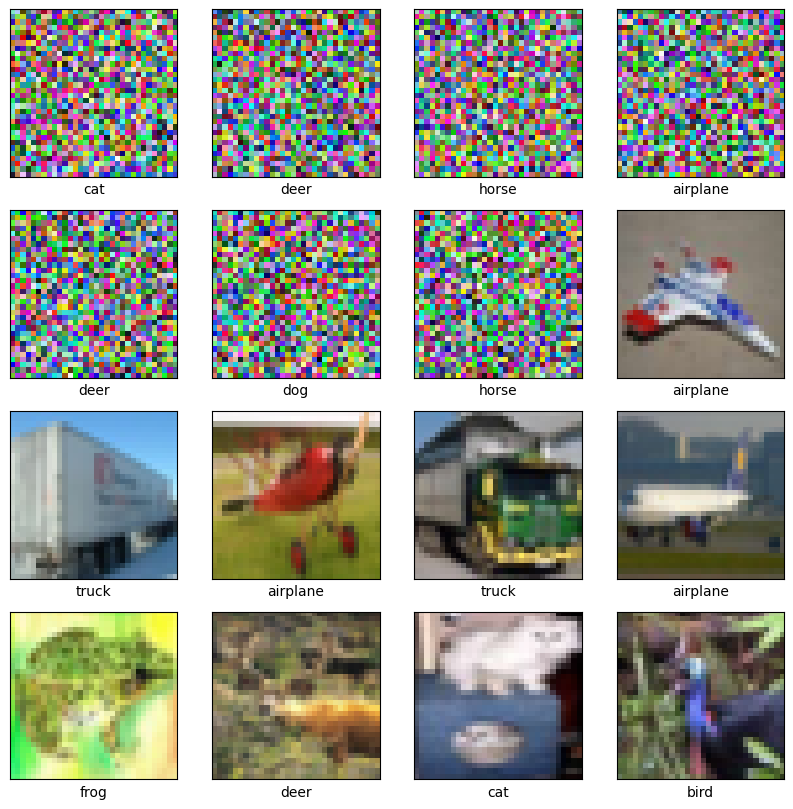

In [ ]:
visualize_buffer_samples(buffer, num_samples=16, p_new=0.5)

### JEM Training

In [ ]:
def part2_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sb : SampleBuffer, sigma : float = 0.03) -> dict:
    batch_size = len(data)
    x, y = (data + tf.random.normal(data.shape) * sigma), tf.one_hot(label, model.num_classes)

    x_p, y_p = sb.sample_from_buffer(batch_size, p_new = 0.05)


    for i in range(20):
        x_p = sampling_step(model, x_p, y_p)
    sb.add_to_buffer(x_p, y_p)



    with tf.GradientTape() as g:

        # 1. obtainig model output for x and x'
        logits = model(x, training = True)
        logits_p = model(x_p, training = True)
        # 2. calculating cross-entropy and energy values
        centry = tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        energy_value = energy(model, x)
        energy_value_p = energy(model, x_p)
        # 3. aggregating and calculating the final loss
        loss = centry + energy_value - energy_value_p
        loss = tf.reduce_mean(loss)

    centry = tf.reduce_mean(centry)
    grad = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return {
        "loss": loss.numpy(),
        "class_loss": centry.numpy()
    }

In [ ]:
def train_loop_2(model, optimizer, train_step, epochs : int = 5, save_interval : int = 1, buffer : SampleBuffer | None = None) -> SampleBuffer:
    if buffer is None:
        buffer = SampleBuffer(X_train[0].shape, n_class)
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Executing a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y, buffer)
                epoch_loss += loss_dict["loss"]

                # Accumulating number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Save the model weights after 5 epochs
        if epoch % save_interval == 0:
            model.save_weights(f'/content/drive/MyDrive/training_progress/buf/model2-{epoch}.weights.h5')

    return buffer

### Execute training

In [ ]:
model_2 = WRN(num_classes=n_class)
optimizer_2 = optimizers.Adam(learning_rate=learning_rate)

In [ ]:
buf = train_loop_2(model_2, optimizer_2, part2_train_step, 2)

Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.20batch/s]


Test Accuracy: 28.18%
Epoch 1, Average Loss: 3.0021


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s]

Test Accuracy: 30.58%
Epoch 2, Average Loss: 2.1580


In [ ]:
import pickle
os.makedirs(os.path.dirname(save_dir_buf), exist_ok=True)

with open(os.path.join(save_dir_buf, 'buffer_data.pkl'), 'wb') as f:
    pickle.dump(buf, f)

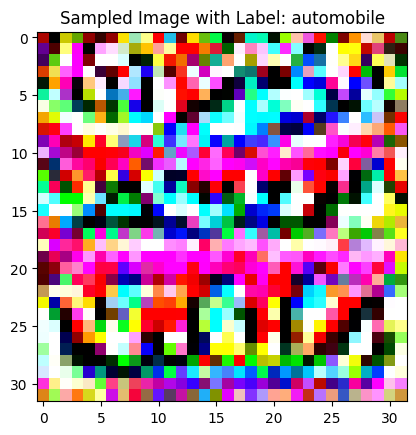

In [ ]:
## Ilustrating the sampling process from a random noise image

sample_image = tf.random.uniform(shape=(1, 32, 32, 3), minval=0, maxval=1)
for i in range(100): #sampling
  sample_image = sampling_step(model, sample_image, label = tf.constant(1), step_size=0.1, noise_amp=0.01)

#visualizing the sample_image
plt.title("Sampled Image with Label: " + image_labels[1])
plt.imshow(sample_image.numpy()[0])

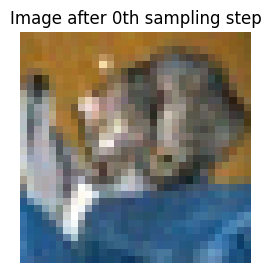

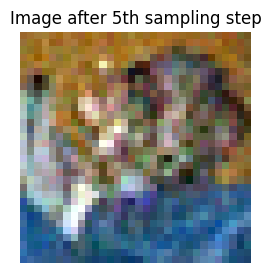

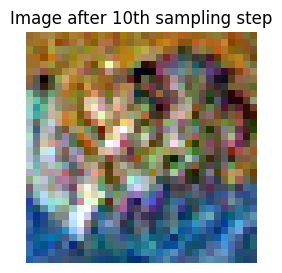

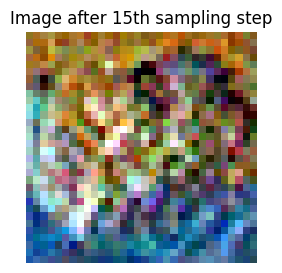

In [ ]:
#Illustrating the sampling process from a real image
real_image = test_dataset.take(1).get_single_element()[0][0]
real_image = tf.expand_dims(real_image, 0)
real_label = test_dataset.take(1).get_single_element()[1][0]

for index in range(20):
    real_image = sampling_step(model, real_image, real_label, step_size=0.1)
    if index % 5 == 0:
        plt.figure(figsize=(3, 3))
        plt.title(f"Image after {index}th sampling step")
        plt.imshow(real_image[0].numpy())
        plt.axis('off')
        plt.show()

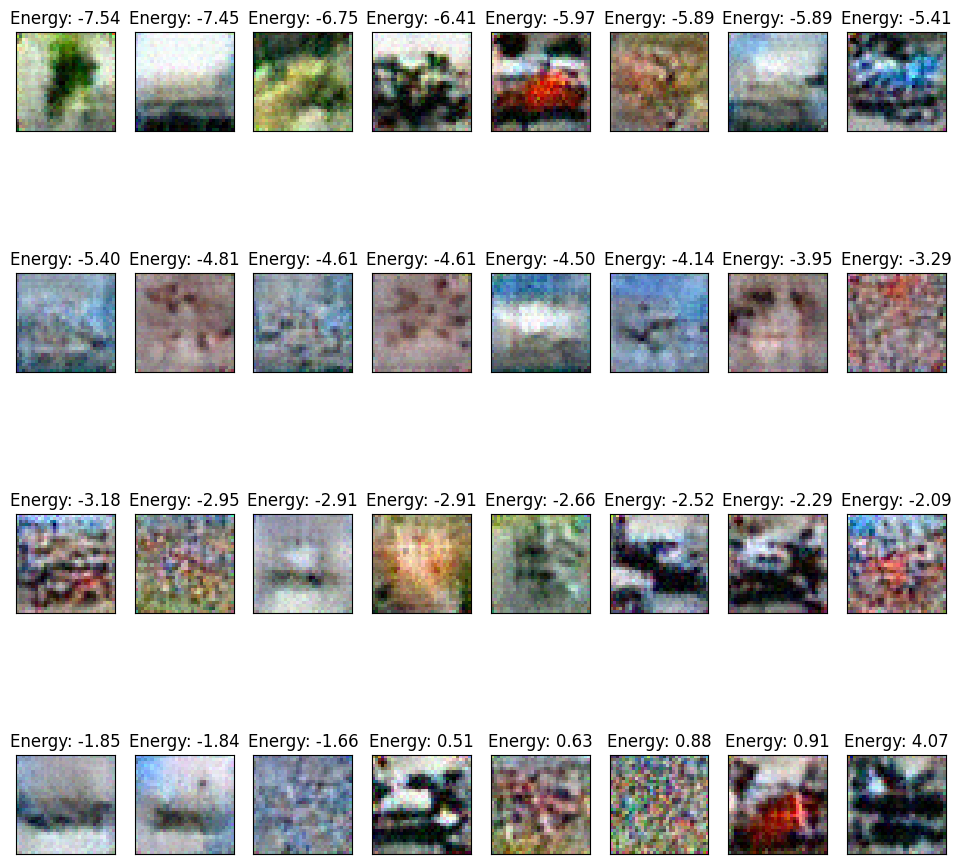

In [ ]:
# Calculating energies of the samples

with open(os.path.join(save_dir_buf, 'buffer_data.pkl'), 'rb') as f:
    buffer = pickle.load(f)

# we sample from buffer
samples, labels = buffer.sample_from_buffer(32, p_new=0)

# calculating energies of samples
energies = [energy(model, tf.expand_dims(sample, 0), label).numpy()[0] for sample, label in zip(samples, labels)]

# sorting the energy values and their samples
sorted_indices = np.argsort(energies)
sorted_samples = [samples[i].numpy() for i in sorted_indices]

# visualizing the samples
plt.figure(figsize=(12, 12))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sorted_samples[i])
    plt.title(f"Energy: {energies[sorted_indices[i]]:.2f}")
plt.show()

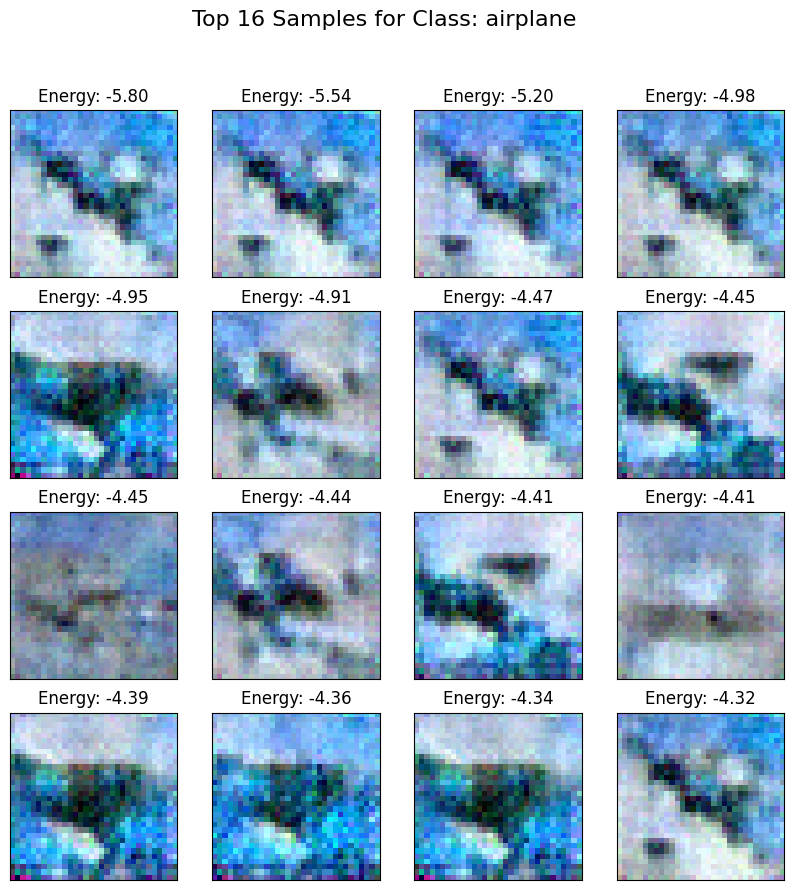

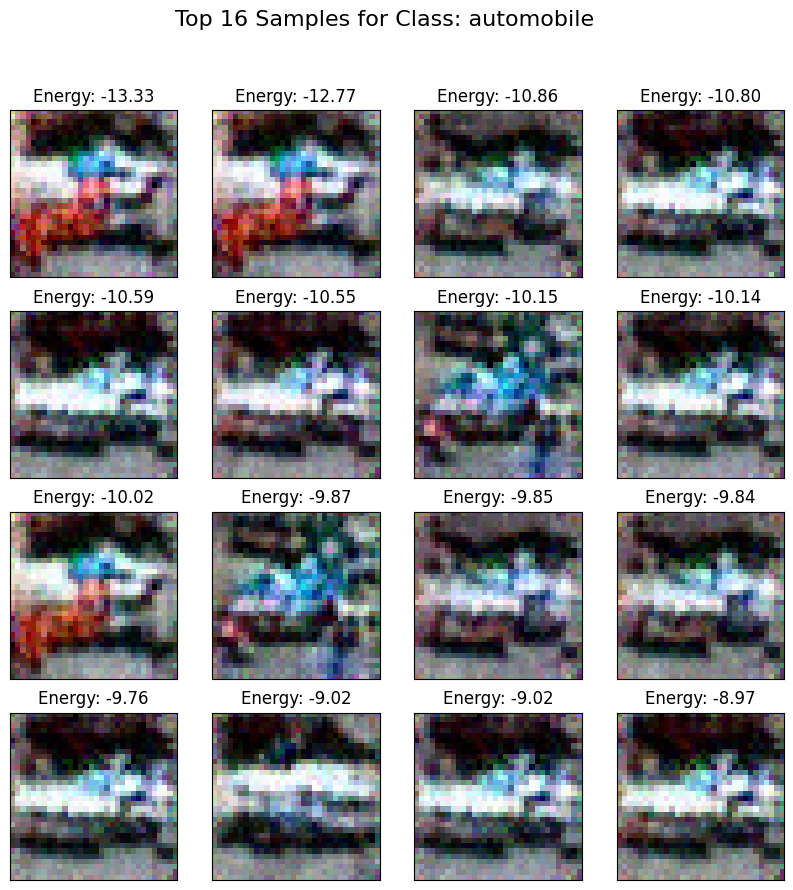

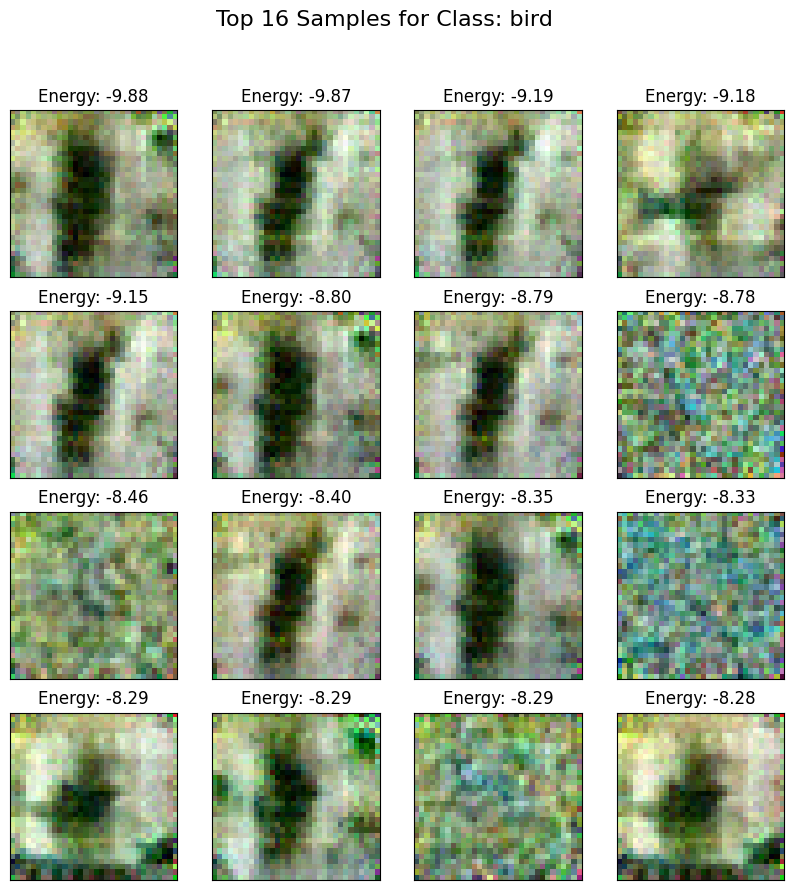

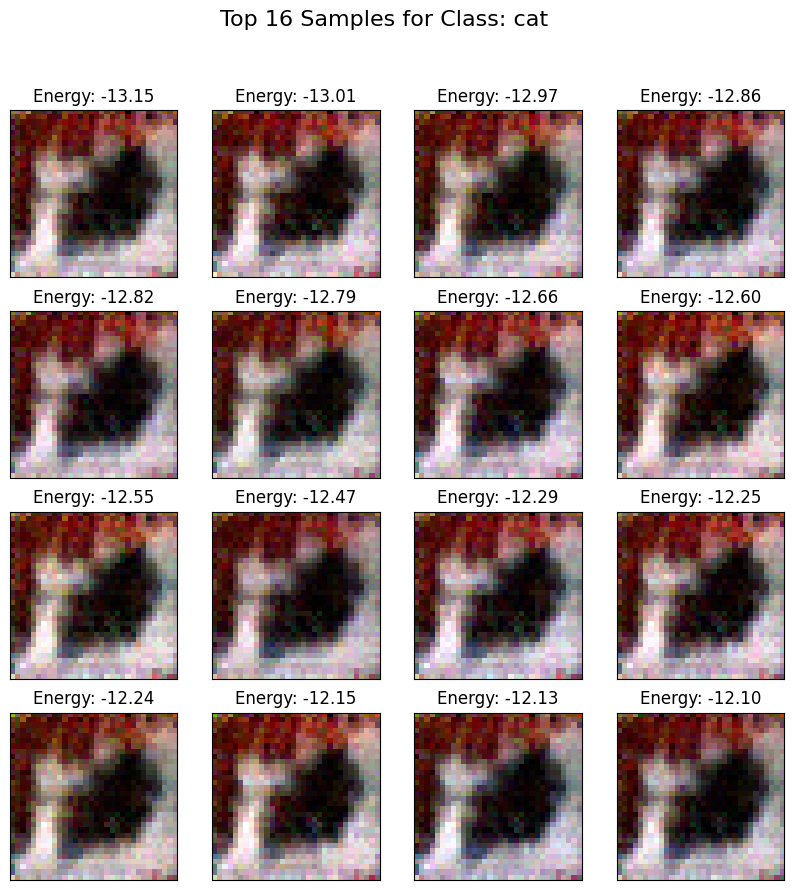

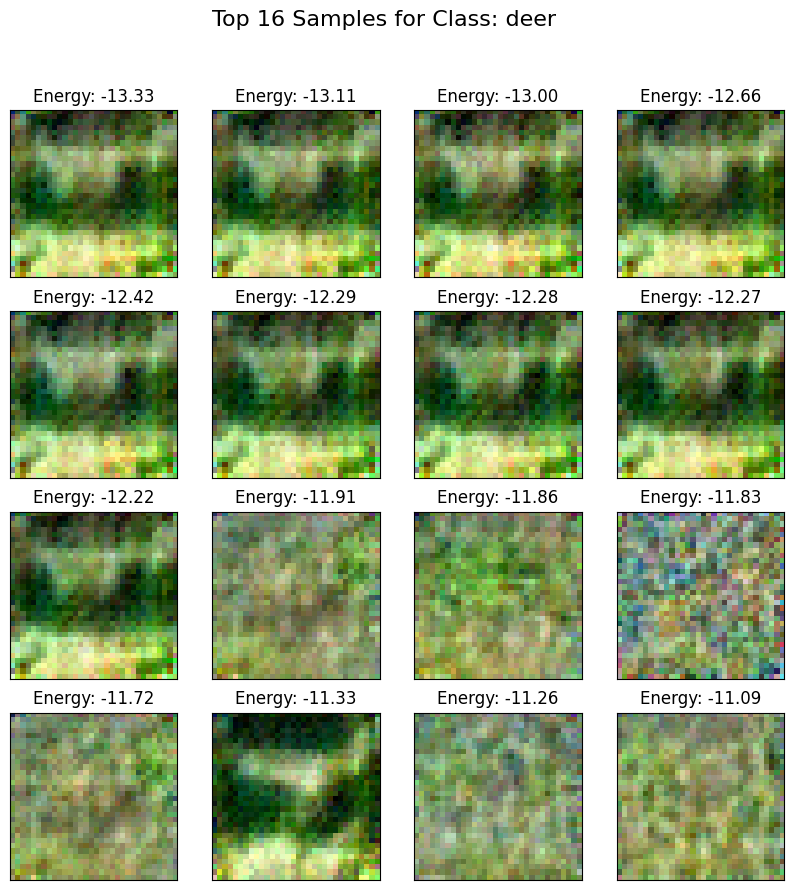

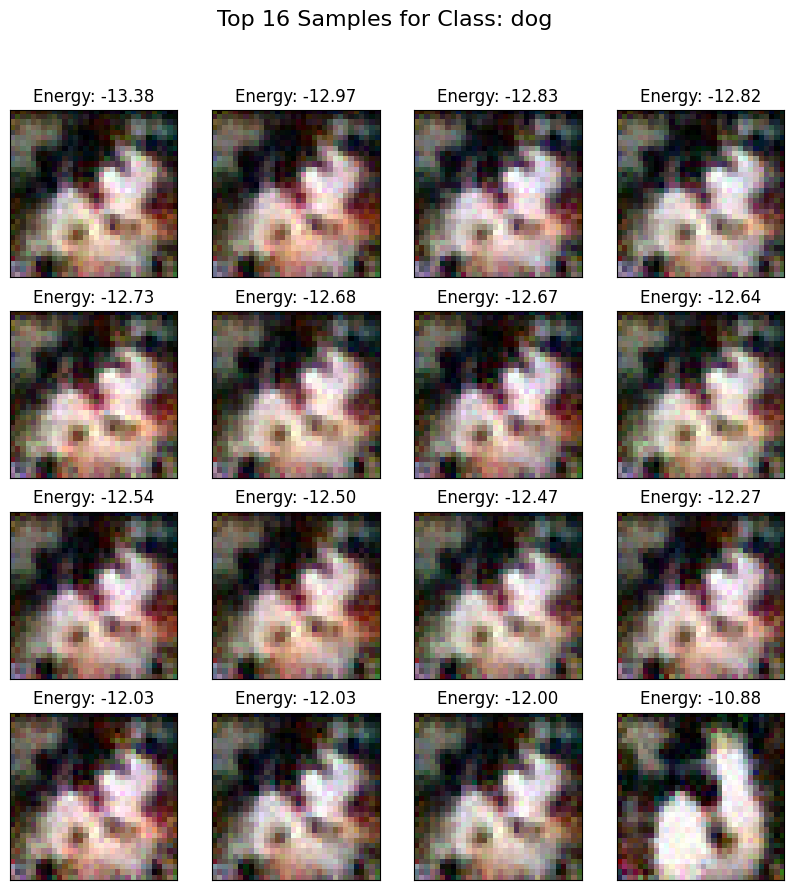

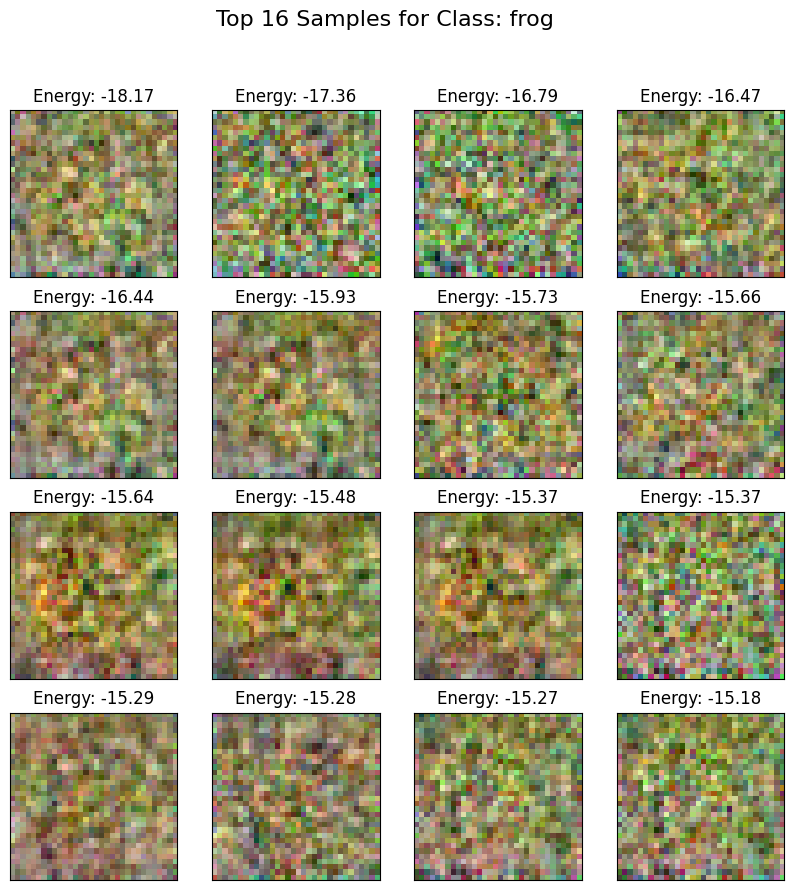

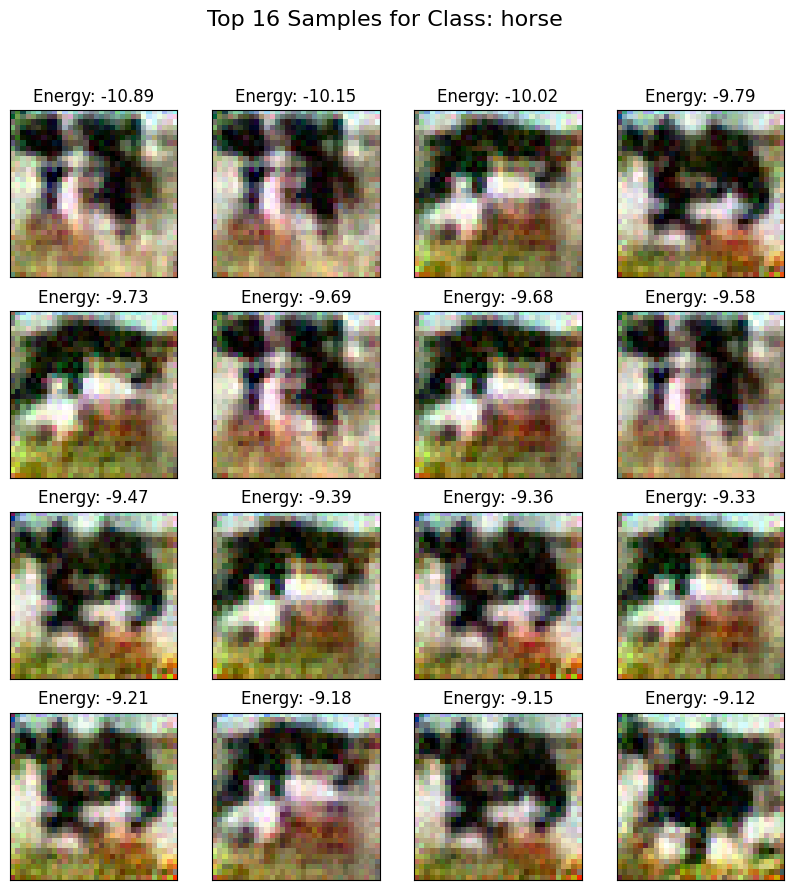

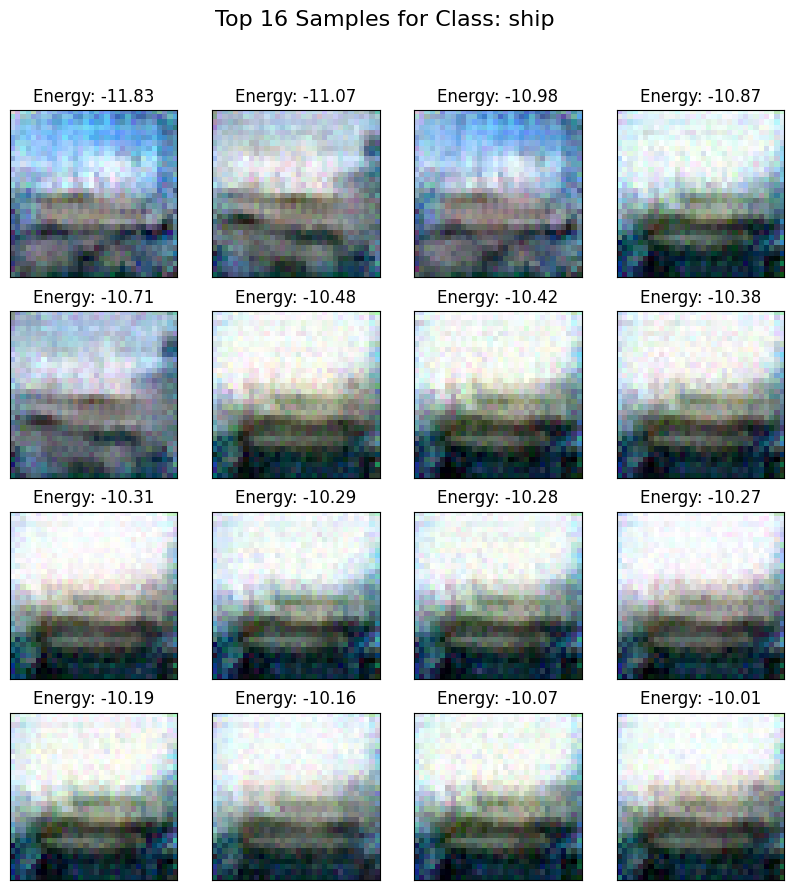

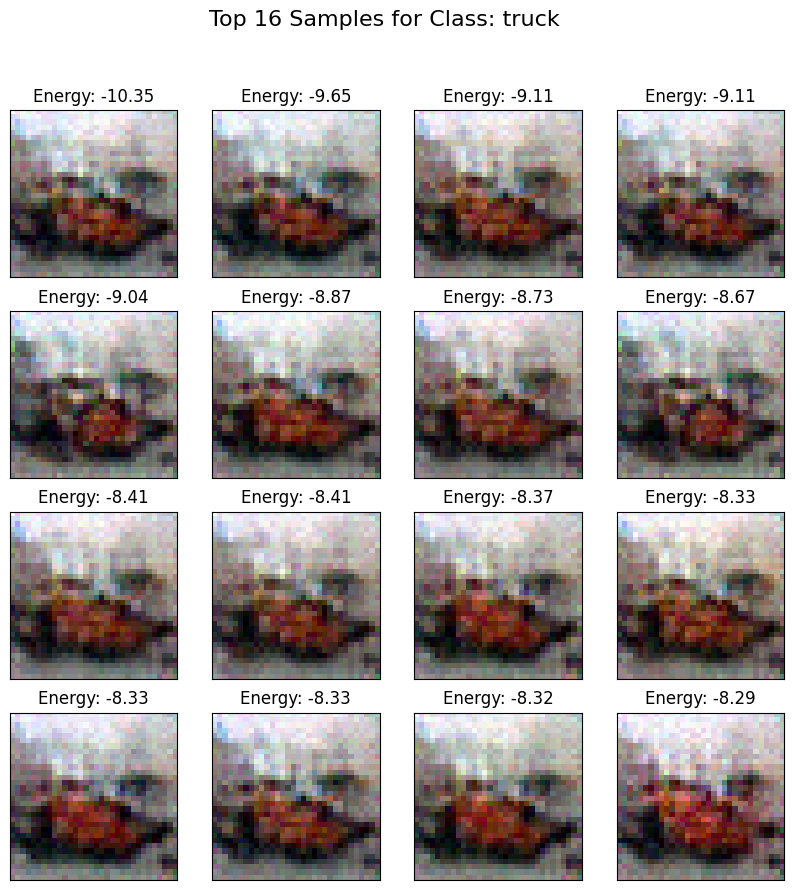

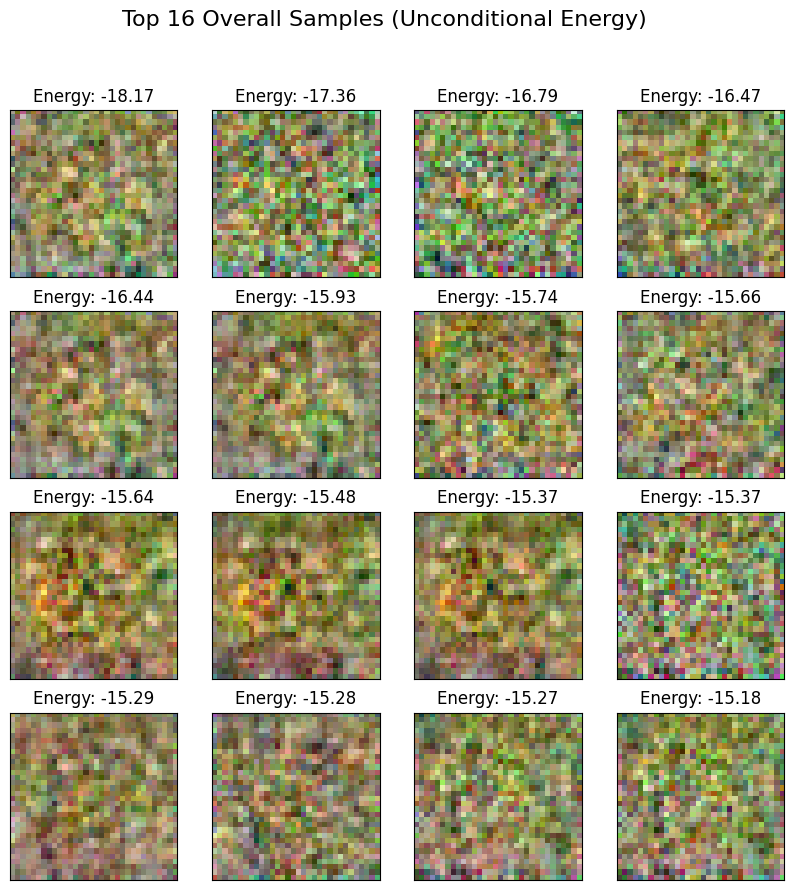

In [ ]:
# Visualizing the top k samples for each class based on conditional energy
top_k = 16

for class_idx in range(n_class):
    #samples and labels for the current class
    class_samples = [sample for sample, label in buffer.buffer if label.numpy() == class_idx]
    class_labels = [class_idx] * len(class_samples)

    # calculating the conditional energies
    energies = [energy(model, tf.expand_dims(sample, 0), label).numpy()[0] for sample, label in zip(class_samples, class_labels)]

    # sorting samples by energy
    sorted_indices = np.argsort(energies)
    sorted_samples = [class_samples[i].numpy() for i in sorted_indices]

    # visualising the top k samples for the current class
    plt.figure(figsize=(10, 10))
    plt.suptitle(f"Top {top_k} Samples for Class: {image_labels[class_idx]}", fontsize=16)
    for i in range(top_k):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sorted_samples[i])
        plt.title(f"Energy: {energies[sorted_indices[i]]:.2f}")
    plt.show()

# Top 16 samples overall by conditional energy

all_samples = [sample for sample, label in buffer.buffer]

# calculating unconditional energies
energies = [energy(model, tf.expand_dims(sample, 0)).numpy()[0] for sample in all_samples]

# sorting all samples by energy
sorted_indices = np.argsort(energies)
sorted_samples = [all_samples[i].numpy() for i in sorted_indices]

plt.figure(figsize=(10, 10))
plt.suptitle(f"Top {top_k} Overall Samples (Unconditional Energy)", fontsize=16)
for i in range(top_k):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sorted_samples[i])
    plt.title(f"Energy: {energies[sorted_indices[i]]:.2f}")
plt.show()


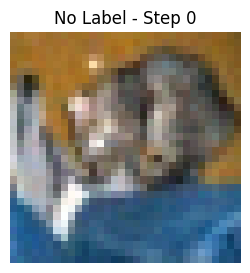

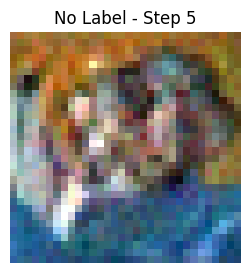

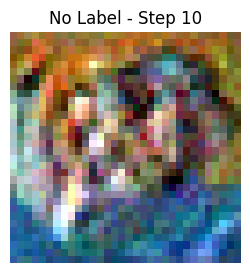

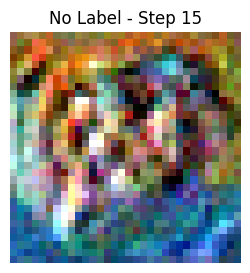

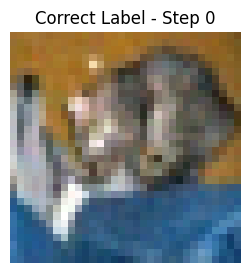

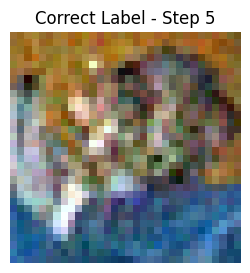

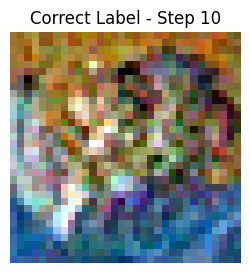

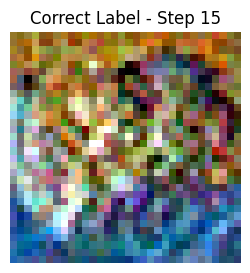

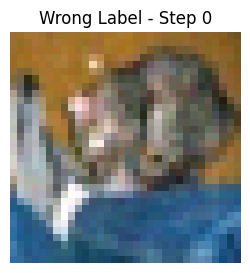

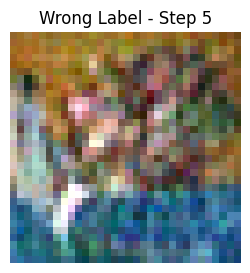

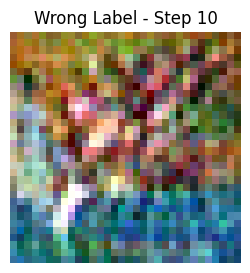

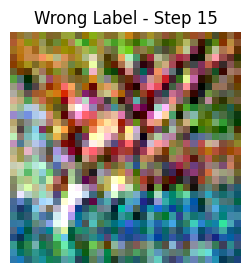

In [ ]:
# Visualizing the sampling process with different labels 
# 1. when the label is not provided
# 2. when correct label is provided
# 3. when incorrect label is provided, and we set the label to be (label + 1) % n_class

real_image_2 = X_test_p[0]
real_label_2 = Y_test_p[0]

# with no label

image_no_label = tf.expand_dims(real_image_2, 0)
for i in range(20):
    image_no_label = sampling_step(model, image_no_label, step_size = 0.1)
    if i % 5 == 0:  # Visualize every 5 steps
        plt.figure(figsize=(3, 3))
        plt.title(f"No Label - Step {i}")
        plt.imshow(image_no_label[0].numpy())
        plt.axis('off')
        plt.show()

# with correct Label

image_correct_label = tf.expand_dims(real_image_2, 0) # Changed real_image to real_image_2
for i in range(20):
    image_correct_label = sampling_step(model, image_correct_label, real_label_2, step_size = 0.1)
    if i % 5 == 0:
        plt.figure(figsize=(3, 3))
        plt.title(f"Correct Label - Step {i}")
        plt.imshow(image_correct_label[0].numpy())
        plt.axis('off')
        plt.show()

# with wrong label

wrong_label = (real_label_2 + 1) % n_class  # Changed real_label to real_label_2
image_wrong_label = tf.expand_dims(real_image_2, 0) # Changed real_image to real_image_2
for i in range(20):
    image_wrong_label = sampling_step(model, image_wrong_label, wrong_label, step_size = 0.1)
    if i % 5 == 0:
        plt.figure(figsize=(3, 3))
        plt.title(f"Wrong Label - Step {i}")
        plt.imshow(image_wrong_label[0].numpy())
        plt.axis('off')
        plt.show()